# Human Activity Recognition from Smart Phone Data
Recognizing human activities from temporal streams of sensory data observations is a very important task on a wide variety of applications in context recognition. Human activities are hierarchical in nature, i.e. the complex activities can be decomposed to several simpler ones. Human activity recognition is the problem of classifying sequences of accelerometer data recorded by pre-installed sensors in smart phones into known well-defined movements to make it ready for predictive modelling.

__Question:__

Perform activity recognition on the dataset using a hidden markov model. Then perform the same task using a different classification algorithm (logistic regression/decision tree) of your choice and compare the performance of the two algorithms

Dataset Link: Human Activity Recognition with Smartphones
https://www.kaggle.com/uciml/human-activity-recognition-with-smartphones

In [1]:
#pip install plotly

In [2]:
#conda install -c conda-forge cycler

In [3]:
#conda install -c anaconda scipy

In [4]:
#conda install -c conda-forge lightgbm
#pip install lightgbm

In [5]:
#conda install -c lightsource2-tag collection

In [6]:
# To store data
import pandas as pd

# To do linear algebra
import numpy as np
from numpy import pi

# To create plots
from matplotlib.colors import rgb2hex
from matplotlib.cm import get_cmap
import matplotlib.pyplot as plt

# To create nicer plots
import seaborn as sns

# To create interactive plots
from plotly.offline import init_notebook_mode, iplot
import plotly.graph_objs as go
init_notebook_mode(connected=True)

# To get new datatypes and functions
from collections import Counter
from cycler import cycler

# To investigate distributions
from scipy.stats import norm, skew, probplot
from scipy.optimize import curve_fit

# To build models
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# To gbm light
from lightgbm import LGBMClassifier

# To measure time
from time import time

In [7]:
# Load datasets
train_df = pd.read_csv('train_HA.csv')
test_df = pd.read_csv('test_HA.csv')

In [8]:
# Combine boths dataframes
train_df['Data'] = 'Train'
test_df['Data'] = 'Test'

In [9]:
both_df = pd.concat([train_df, test_df], axis=0).reset_index(drop=True)
both_df['subject'] = '#' + both_df['subject'].astype(str)

In [10]:
# Create label
label = both_df.pop('Activity')

print('Shape Train:\t{}'.format(train_df.shape))
print('Shape Test:\t{}\n'.format(test_df.shape))

train_df.head()

Shape Train:	(7352, 564)
Shape Test:	(2947, 564)



,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",subject,Activity,Data
0,0.288585,-0.020294,-0.132905,-0.995279,-0.983111,-0.913526,-0.995112,-0.983185,-0.923527,-0.934724,...,-0.112754,0.030400,-0.464761,-0.018446,-0.841247,0.179941,-0.058627,1,STANDING,Train
1,0.278419,-0.016411,-0.123520,-0.998245,-0.975300,-0.960322,-0.998807,-0.974914,-0.957686,-0.943068,...,0.053477,-0.007435,-0.732626,0.703511,-0.844788,0.180289,-0.054317,1,STANDING,Train
2,0.279653,-0.019467,-0.113462,-0.995380,-0.967187,-0.978944,-0.996520,-0.963668,-0.977469,-0.938692,...,-0.118559,0.177899,0.100699,0.808529,-0.848933,0.180637,-0.049118,1,STANDING,Train
3,0.279174,-0.026201,-0.123283,-0.996091,-0.983403,-0.990675,-0.997099,-0.982750,-0.989302,-0.938692,...,-0.036788,-0.012892,0.640011,-0.485366,-0.848649,0.181935,-0.047663,1,STANDING,Train
4,0.276629,-0.016570,-0.115362,-0.998139,-0.980817,-0.990482,-0.998321,-0.979672,-0.990441,-0.942469,...,0.123320,0.122542,0.693578,-0.615971,-0.847865,0.185151,-0.043892,1,STANDING,Train


In [11]:
# Group and count main names of columns
pd.DataFrame.from_dict(Counter([col.split('-')[0].split('(')[0] for col in both_df.columns]), orient='index').rename(columns={0:'count'}).sort_values('count', ascending=False)

,count
fBodyAcc,79
fBodyGyro,79
fBodyAccJerk,79
tGravityAcc,40
tBodyAcc,40
tBodyGyroJerk,40
tBodyGyro,40
tBodyAccJerk,40
tBodyAccMag,13
tGravityAccMag,13


In [12]:
# Get null values and dataframe information
print('Null Values In DataFrame: {}\n'.format(both_df.isna().sum().sum()))
both_df.info()

Null Values In DataFrame: 0

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10299 entries, 0 to 10298
Columns: 563 entries, tBodyAcc-mean()-X to Data
dtypes: float64(561), object(2)
memory usage: 44.2+ MB


In [13]:
# Plotting data
label_counts = label.value_counts()

# Get colors
n = label_counts.shape[0]
colormap = get_cmap('viridis')
colors = [rgb2hex(colormap(col)) for col in np.arange(0, 1.01, 1/(n-1))]

In [14]:
# Create plot
data = go.Bar(x = label_counts.index,
              y = label_counts,
              marker = dict(color = colors))

layout = go.Layout(title = 'Smartphone Activity Label Distribution',
                   xaxis = dict(title = 'Activity'),
                   yaxis = dict(title = 'Count'))

fig = go.Figure(data=[data], layout=layout)
iplot(fig)

In [15]:
# Create datasets
tsne_data = both_df.copy()
data_data = tsne_data.pop('Data')
subject_data = tsne_data.pop('subject')

In [16]:
# Scale data
scl = StandardScaler()
tsne_data = scl.fit_transform(tsne_data)

In [17]:
# Reduce dimensions (speed up)
pca = PCA(n_components=0.9, random_state=3)
tsne_data = pca.fit_transform(tsne_data)

# Transform data
tsne = TSNE(random_state=3)
tsne_transformed = tsne.fit_transform(tsne_data)

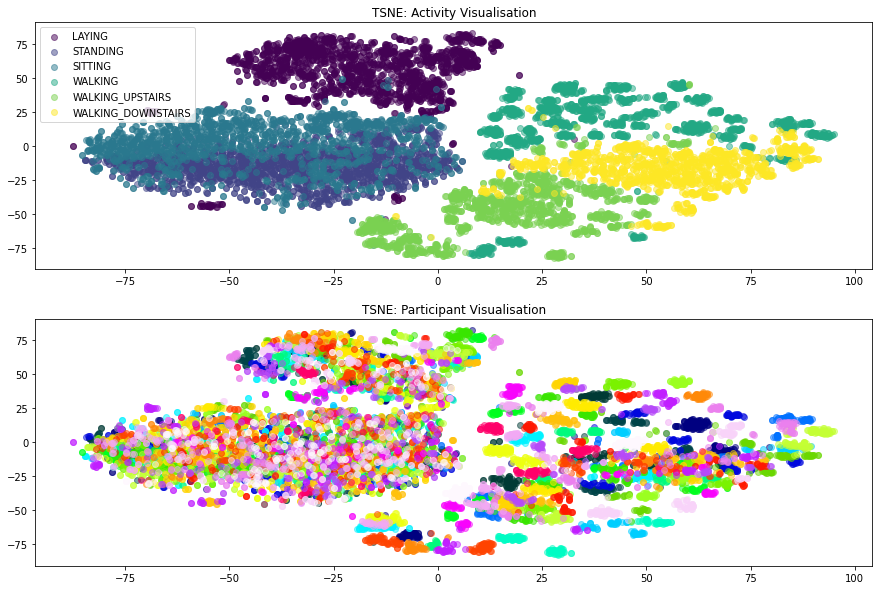

In [18]:
# Create subplots
fig, axarr = plt.subplots(2, 1, figsize=(15,10))

### Plot Activities
# Get colors
n = label.unique().shape[0]
colormap = get_cmap('viridis')
colors = [rgb2hex(colormap(col)) for col in np.arange(0, 1.01, 1/(n-1))]

# Plot each activity
for i, group in enumerate(label_counts.index):
    # Mask to separate sets
    mask = (label==group).values
    axarr[0].scatter(x=tsne_transformed[mask][:,0], y=tsne_transformed[mask][:,1], c=colors[i], alpha=0.5, label=group)
axarr[0].set_title('TSNE: Activity Visualisation')
axarr[0].legend()

### Plot Subjects
# Get colors
n = subject_data.unique().shape[0]
colormap = get_cmap('gist_ncar')
colors = [rgb2hex(colormap(col)) for col in np.arange(0, 1.01, 1/(n-1))]

# Plot each participant
for i, group in enumerate(subject_data.unique()):
    # Mask to separate sets
    mask = (subject_data==group).values
    axarr[1].scatter(x=tsne_transformed[mask][:,0], y=tsne_transformed[mask][:,1], c=colors[i], alpha=0.5, label=group)

axarr[1].set_title('TSNE: Participant Visualisation')
plt.show()

In [19]:
# Split training testing data
enc = LabelEncoder()
label_encoded = enc.fit_transform(label)
X_train, X_test, y_train, y_test = train_test_split(tsne_data, label_encoded, random_state=3)

In [20]:
# Create the model
lgbm = LGBMClassifier(n_estimators=500, random_state=3)
lgbm = lgbm.fit(X_train, y_train)

In [21]:
# Test the model
score = accuracy_score(y_true=y_test, y_pred=lgbm.predict(X_test))
print('Accuracy on testset:\t{:.4f}\n'.format(score))

Accuracy on testset:	0.9569



In [22]:
# Store the data
data = []
# Iterate over each activity
for activity in label_counts.index:
    # Create dataset
    act_data = both_df[label==activity].copy()
    act_data_data = act_data.pop('Data')
    act_subject_data = act_data.pop('subject')
    
    # Scale data
    scl = StandardScaler()
    act_data = scl.fit_transform(act_data)

    # Reduce dimensions
    pca = PCA(n_components=0.9, random_state=3)
    act_data = pca.fit_transform(act_data)

    
    # Split training testing data
    enc = LabelEncoder()
    label_encoded = enc.fit_transform(act_subject_data)
    X_train, X_test, y_train, y_test = train_test_split(act_data, label_encoded, random_state=3)


    # Fit basic model
    print('Activity: {}'.format(activity))
    lgbm = LGBMClassifier(n_estimators=500, random_state=3)
    lgbm = lgbm.fit(X_train, y_train)
    
    score = accuracy_score(y_true=y_test, y_pred=lgbm.predict(X_test))
    print('Accuracy on testset:\t{:.4f}\n'.format(score))
    data.append([activity, score])

Activity: LAYING
Accuracy on testset:	0.6461

Activity: STANDING
Accuracy on testset:	0.5367

Activity: SITTING
Accuracy on testset:	0.5303

Activity: WALKING
Accuracy on testset:	0.9606

Activity: WALKING_UPSTAIRS
Accuracy on testset:	0.9249

Activity: WALKING_DOWNSTAIRS
Accuracy on testset:	0.9148



In [23]:
# Create duration datafrae
duration_df = (both_df.groupby([label, subject_data])['Data'].count().reset_index().groupby('Activity').agg({'Data':'mean'}) * 1.28).rename(columns={'Data':'Seconds'})
activity_df = pd.DataFrame(data, columns=['Activity', 'Accuracy']).set_index('Activity')
activity_df.join(duration_df)

,Accuracy,Seconds
Activity,,
LAYING,0.646091,82.944000
STANDING,0.536688,81.322667
SITTING,0.530337,75.818667
WALKING,0.960557,73.472000
WALKING_UPSTAIRS,0.924870,65.877333
WALKING_DOWNSTAIRS,0.914773,59.989333


In [24]:
# Create dataset
tsne_data = both_df[label=='WALKING'].copy()
data_data = tsne_data.pop('Data')
subject_data = tsne_data.pop('subject')

In [25]:
# Scale data
scl = StandardScaler()
tsne_data = scl.fit_transform(tsne_data)

In [26]:
# Split training testing data
enc = LabelEncoder()
label_encoded = enc.fit_transform(subject_data)
X_train, X_test, y_train, y_test = train_test_split(tsne_data, label_encoded, random_state=3)

In [27]:
# Create model
lgbm = LGBMClassifier(n_estimators=500, random_state=3)
lgbm = lgbm.fit(X_train, y_train)

# Get importances
features = both_df.drop(['Data', 'subject'], axis=1).columns
importances = lgbm.feature_importances_

In [28]:
# Sum importances
data = {'Gyroscope':0, 'Accelerometer':0}
for importance, feature in zip(importances, features):
    if 'Gyro' in feature:
        data['Gyroscope'] += importance
    if 'Acc' in feature:
        data['Accelerometer'] += importance

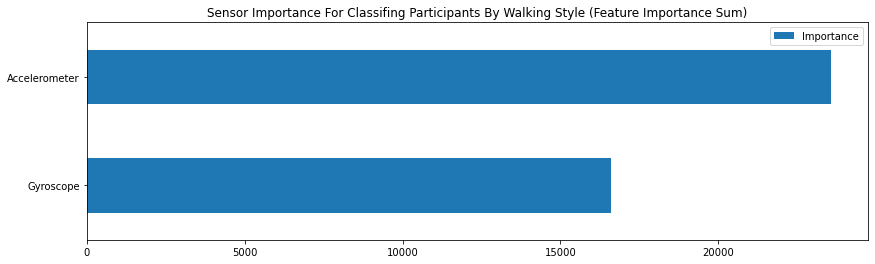

In [29]:
# Create dataframe and plot
sensor_df = pd.DataFrame.from_dict(data, orient='index').rename(columns={0:'Importance'})
sensor_df.plot(kind='barh', figsize=(14,4), title='Sensor Importance For Classifing Participants By Walking Style (Feature Importance Sum)')
plt.show()

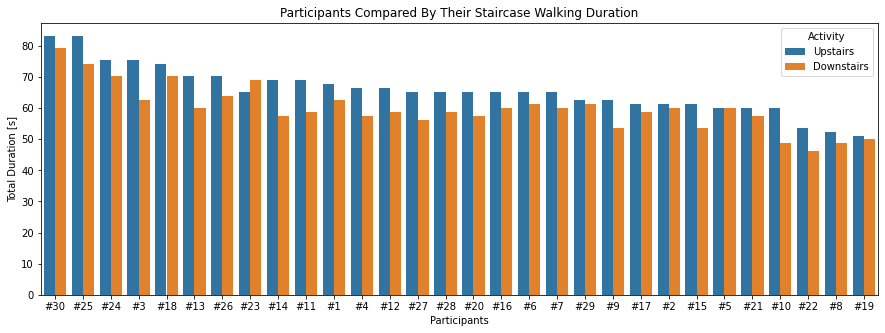

In [30]:
# Group the data by participant and compute total duration of staircase walking
mask = label.isin(['WALKING_UPSTAIRS', 'WALKING_DOWNSTAIRS'])
duration_df = (both_df[mask].groupby([label[mask], 'subject'])['Data'].count() * 1.28)

# Create plot
plot_data = duration_df.reset_index().sort_values('Data', ascending=False)
plot_data['Activity'] = plot_data['Activity'].map({'WALKING_UPSTAIRS':'Upstairs', 'WALKING_DOWNSTAIRS':'Downstairs'})
plt.figure(figsize=(15,5))
sns.barplot(data=plot_data, x='subject', y='Data', hue='Activity')
plt.title('Participants Compared By Their Staircase Walking Duration')
plt.xlabel('Participants')
plt.ylabel('Total Duration [s]')
plt.show()

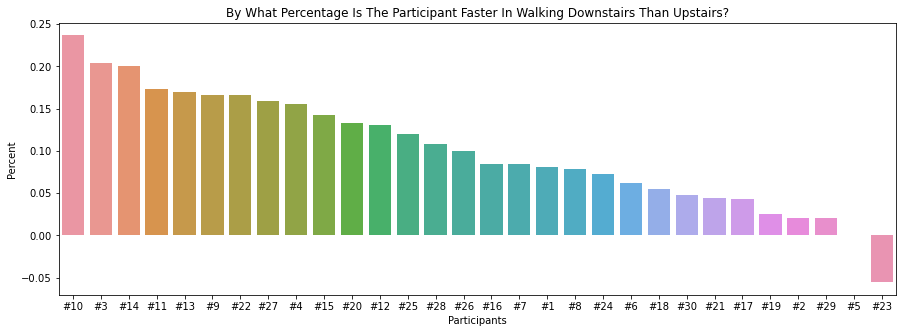

In [31]:
# Create data and plot
plt.figure(figsize=(15,5))
plot_data = ((duration_df.loc['WALKING_UPSTAIRS'] / duration_df.loc['WALKING_DOWNSTAIRS']) -1).sort_values(ascending=False)
sns.barplot(x=plot_data.index, y=plot_data)
plt.title('By What Percentage Is The Participant Faster In Walking Downstairs Than Upstairs?')
plt.xlabel('Participants')
plt.ylabel('Percent')
plt.show()

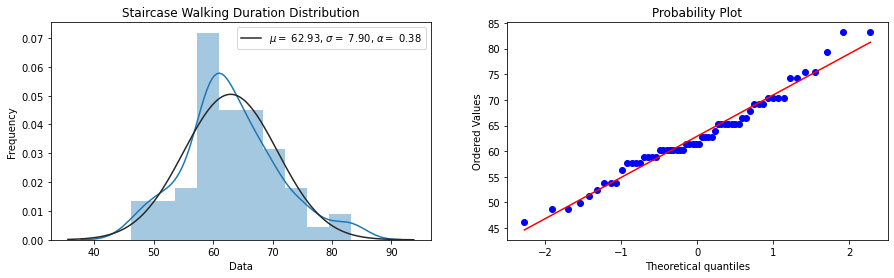

In [32]:
def plotSkew(x):
    # Fit label to norm
    (mu, sigma) = norm.fit(x)
    alpha = skew(x)

    fig, axarr = plt.subplots(1, 2, figsize=(15,4))

    # Plot label and fit
    sns.distplot(x , fit=norm, ax=axarr[0])
    axarr[0].legend(['$\mu=$ {:.2f}, $\sigma=$ {:.2f}, $\\alpha=$ {:.2f}'.format(mu, sigma, alpha)], loc='best')
    axarr[0].set_title('Staircase Walking Duration Distribution')
    axarr[0].set_ylabel('Frequency')

    # Plot probability plot
    res = probplot(x, plot=axarr[1])
    plt.show()
    
    
plotSkew(duration_df)

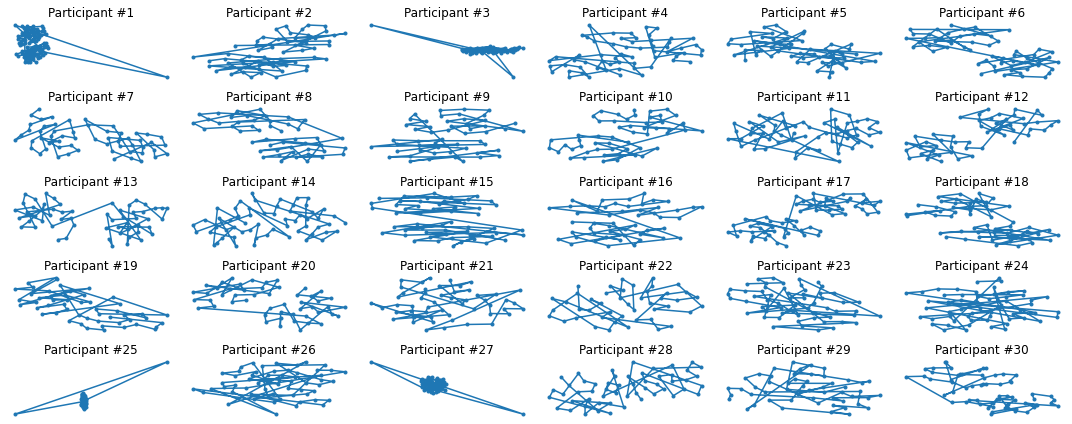

In [33]:
fig, axarr = plt.subplots(5, 6, figsize=(15,6))

for person in range(0, 30):
    # Get data
    single_person = both_df[(label=='WALKING') & (both_df['subject']=='#{}'.format(person+1))].drop(['subject', 'Data'], axis=1)
    # Scale data
    scl = StandardScaler()
    tsne_data = scl.fit_transform(single_person)
    # Reduce dimensions
    pca = PCA(n_components=0.9, random_state=3)
    tsne_data = pca.fit_transform(tsne_data)
    # Transform data
    tsne = TSNE(random_state=3)
    tsne_transformed = tsne.fit_transform(tsne_data)
    
    # Create plot
    axarr[person//6][person%6].plot(tsne_transformed[:,0], tsne_transformed[:,1], '.-')
    axarr[person//6][person%6].set_title('Participant #{}'.format(person+1))
    axarr[person//6][person%6].axis('off')
    
plt.tight_layout()
plt.show()

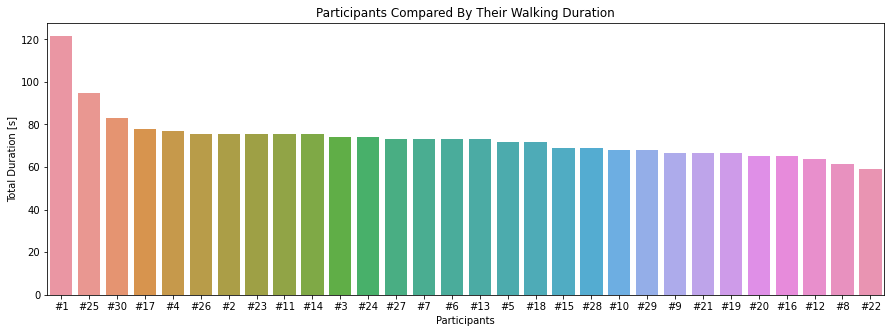

In [34]:
# Group the data by participant and compute total duration of walking
mask = label=='WALKING'
duration_df = (both_df[mask].groupby('subject')['Data'].count() * 1.28)

# Create plot
plot_data = duration_df.reset_index().sort_values('Data', ascending=False)

plt.figure(figsize=(15,5))
sns.barplot(data=plot_data, x='subject', y='Data')
plt.title('Participants Compared By Their Walking Duration')
plt.xlabel('Participants')
plt.ylabel('Total Duration [s]')
plt.show()

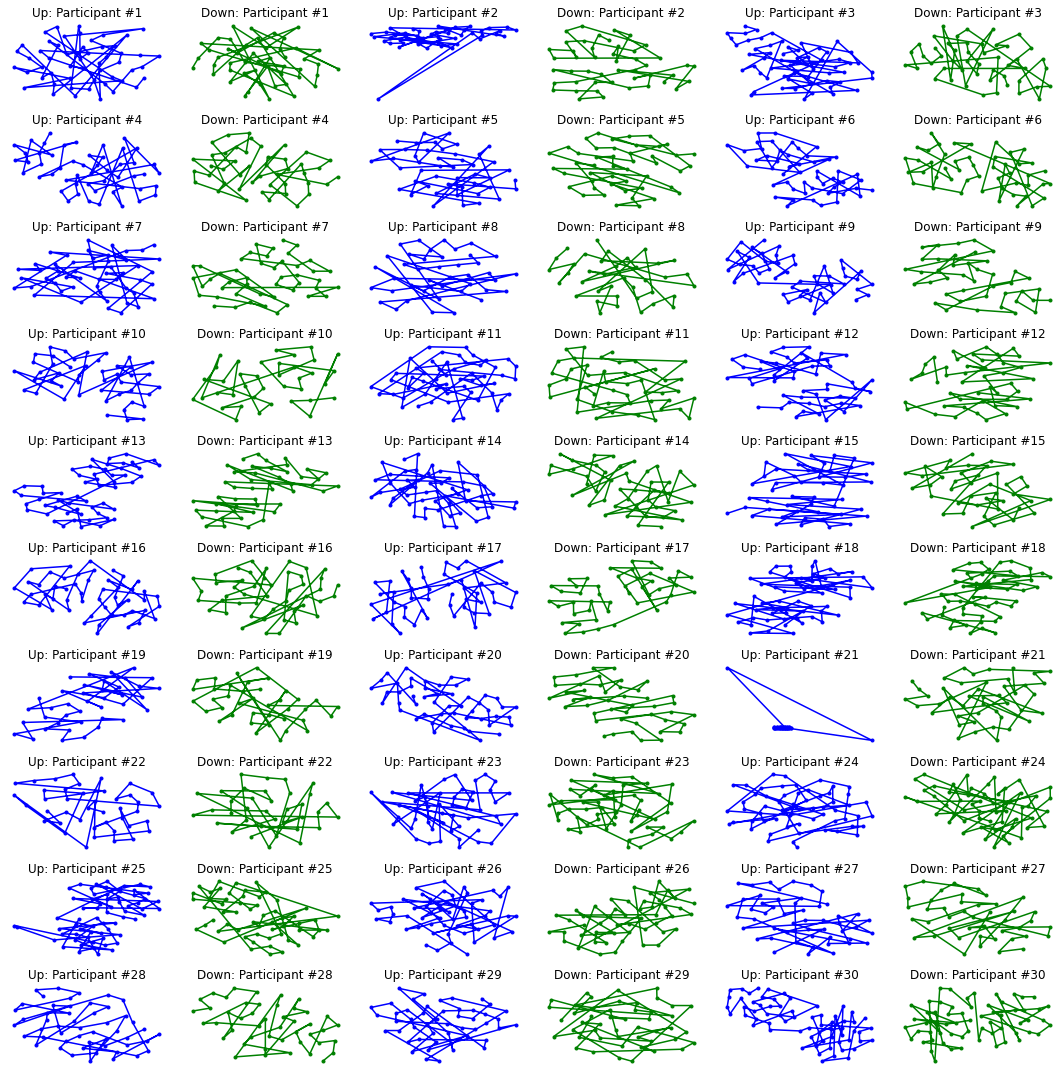

In [35]:
# Create subplots
fig, axarr = plt.subplots(10, 6, figsize=(15,15))

# Iterate over each participant
for person in range(0, 30):
    # Get data
    single_person_up = both_df[(label=='WALKING_UPSTAIRS') & (both_df['subject']=='#{}'.format(person+1))].drop(['subject', 'Data'], axis=1)
    single_person_down = both_df[(label=='WALKING_DOWNSTAIRS') & (both_df['subject']=='#{}'.format(person+1))].drop(['subject', 'Data'], axis=1)
    # Scale data
    scl = StandardScaler()
    tsne_data_up = scl.fit_transform(single_person_up)
    tsne_data_down = scl.fit_transform(single_person_down)
    # Reduce dimensions
    pca = PCA(n_components=0.9, random_state=3)
    tsne_data_up = pca.fit_transform(tsne_data_up)
    tsne_data_down = pca.fit_transform(tsne_data_down)
    # Transform data
    tsne = TSNE(random_state=3)
    tsne_transformed_up = tsne.fit_transform(tsne_data_up)
    tsne_transformed_down = tsne.fit_transform(tsne_data_down)
    
    # Create plot
    axarr[2*person//6][2*person%6].plot(tsne_transformed_up[:,0], tsne_transformed_up[:,1], '.b-')
    axarr[2*person//6][2*person%6].set_title('Up: Participant #{}'.format(person+1))
    axarr[2*person//6][2*person%6].axis('off')
    axarr[2*person//6][(2*person%6)+1].plot(tsne_transformed_down[:,0], tsne_transformed_down[:,1], '.g-')
    axarr[2*person//6][(2*person%6)+1].set_title('Down: Participant #{}'.format(person+1))
    axarr[2*person//6][(2*person%6)+1].axis('off')
    
plt.tight_layout()
plt.show()

In [36]:
# Use SS class fro jdarcy
class SSA(object):    
    __supported_types = (pd.Series, np.ndarray, list)
    
    def __init__(self, tseries, L, save_mem=True):
        '''
        Decomposes the given time series with a singular-spectrum analysis. Assumes the values of the time series are
        recorded at equal intervals.
        
        Parameters
        ----------
        tseries : The original time series, in the form of a Pandas Series, NumPy array or list. 
        L : The window length. Must be an integer 2 <= L <= N/2, where N is the length of the time series.
        save_mem : Conserve memory by not retaining the elementary matrices. Recommended for long time series with
            thousands of values. Defaults to True.
        
        Note: Even if an NumPy array or list is used for the initial time series, all time series returned will be
        in the form of a Pandas Series or DataFrame object.
        '''
        
        # Tedious type-checking for the initial time series
        if not isinstance(tseries, self.__supported_types):
            raise TypeError('Unsupported time series object. Try Pandas Series, NumPy array or list.')
        
        # Checks to save us from ourselves
        self.N = len(tseries)
        if not 2 <= L <= self.N/2:
            raise ValueError('The window length must be in the interval [2, N/2].')
        
        self.L = L
        self.orig_TS = pd.Series(tseries)
        self.K = self.N - self.L + 1
        
        # Embed the time series in a trajectory matrix
        self.X = np.array([self.orig_TS.values[i:L+i] for i in range(0, self.K)]).T
        
        # Decompose the trajectory matrix
        self.U, self.Sigma, VT = np.linalg.svd(self.X)
        self.d = np.linalg.matrix_rank(self.X)
        
        self.TS_comps = np.zeros((self.N, self.d))
        
        if not save_mem:
            # Construct and save all the elementary matrices
            self.X_elem = np.array([ self.Sigma[i]*np.outer(self.U[:,i], VT[i,:]) for i in range(self.d) ])

            # Diagonally average the elementary matrices, store them as columns in array.           
            for i in range(self.d):
                X_rev = self.X_elem[i, ::-1]
                self.TS_comps[:,i] = [X_rev.diagonal(j).mean() for j in range(-X_rev.shape[0]+1, X_rev.shape[1])]
            
            self.V = VT.T
        else:
            # Reconstruct the elementary matrices without storing them
            for i in range(self.d):
                X_elem = self.Sigma[i]*np.outer(self.U[:,i], VT[i,:])
                X_rev = X_elem[::-1]
                self.TS_comps[:,i] = [X_rev.diagonal(j).mean() for j in range(-X_rev.shape[0]+1, X_rev.shape[1])]
            
            self.X_elem = 'Re-run with save_mem=False to retain the elementary matrices.'
            
            # The V array may also be very large under these circumstances, so we won't keep it.
            self.V = 'Re-run with save_mem=False to retain the V matrix.'
        
        # Calculate the w-correlation matrix.
        self.calc_wcorr()
            
    def components_to_df(self, n=0):
        '''
        Returns all the time series components in a single Pandas DataFrame object.
        '''
        if n > 0:
            n = min(n, self.d)
        else:
            n = self.d
        
        # Create list of columns - call them F0, F1, F2, ...
        cols = ['F{}'.format(i) for i in range(n)]
        return pd.DataFrame(self.TS_comps[:, :n], columns=cols, index=self.orig_TS.index)
            
    
    def reconstruct(self, indices):
        '''
        Reconstructs the time series from its elementary components, using the given indices. Returns a Pandas Series
        object with the reconstructed time series.
        
        Parameters
        ----------
        indices: An integer, list of integers or slice(n,m) object, representing the elementary components to sum.
        '''
        if isinstance(indices, int): indices = [indices]
        
        ts_vals = self.TS_comps[:,indices].sum(axis=1)
        return pd.Series(ts_vals, index=self.orig_TS.index)
    
    def calc_wcorr(self):
        '''
        Calculates the w-correlation matrix for the time series.
        '''
             
        # Calculate the weights
        w = np.array(list(np.arange(self.L)+1) + [self.L]*(self.K-self.L-1) + list(np.arange(self.L)+1)[::-1])
        
        def w_inner(F_i, F_j):
            return w.dot(F_i*F_j)
        
        # Calculated weighted norms, ||F_i||_w, then invert.
        F_wnorms = np.array([w_inner(self.TS_comps[:,i], self.TS_comps[:,i]) for i in range(self.d)])
        F_wnorms = F_wnorms**-0.5
        
        # Calculate Wcorr.
        self.Wcorr = np.identity(self.d)
        for i in range(self.d):
            for j in range(i+1,self.d):
                self.Wcorr[i,j] = abs(w_inner(self.TS_comps[:,i], self.TS_comps[:,j]) * F_wnorms[i] * F_wnorms[j])
                self.Wcorr[j,i] = self.Wcorr[i,j]
    
    def plot_wcorr(self, min=None, max=None):
        '''
        Plots the w-correlation matrix for the decomposed time series.
        '''
        if min is None:
            min = 0
        if max is None:
            max = self.d
        
        if self.Wcorr is None:
            self.calc_wcorr()
        
        ax = plt.imshow(self.Wcorr)
        plt.xlabel(r'$\tilde{F}_i$')
        plt.ylabel(r'$\tilde{F}_j$')
        plt.colorbar(ax.colorbar, fraction=0.045)
        ax.colorbar.set_label('$W_{i,j}$')
        plt.clim(0,1)
        
        # For plotting purposes:
        if max == self.d:
            max_rnge = self.d-1
        else:
            max_rnge = max
        
        plt.xlim(min-0.5, max_rnge+0.5)
        plt.ylim(max_rnge+0.5, min-0.5)

In [37]:
# Euclidean norm of the acceleration
walking_series = both_df[(label=='WALKING') & (both_df['subject']=='#1')][['tBodyAcc-mean()-X', 'tBodyAcc-mean()-Y', 'tBodyAcc-mean()-Z']].reset_index(drop=True)
walking_series = (walking_series**2).sum(axis=1)**0.5

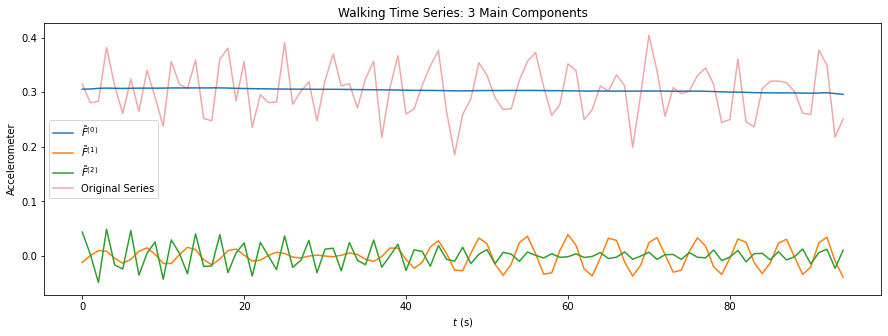

In [38]:
# Decomposing the series
series_ssa = SSA(walking_series, 30)

# Plotting the decomposition
plt.figure(figsize=(15,5))
series_ssa.reconstruct(0).plot()
series_ssa.reconstruct([1,2]).plot()
series_ssa.reconstruct([3,4]).plot()
series_ssa.orig_TS.plot(alpha=0.4)
plt.title('Walking Time Series: 3 Main Components')
plt.xlabel(r'$t$ (s)')
plt.ylabel('Accelerometer')
legend = [r'$\tilde{{F}}^{{({0})}}$'.format(i) for i in range(3)] + ['Original Series']
plt.legend(legend);

In [39]:
# Both walking styles from a single participant
style1 = both_df.loc[78:124][['tBodyAcc-mean()-X', 'tBodyAcc-mean()-Y', 'tBodyAcc-mean()-Z']].reset_index(drop=True)
style1 = ((style1**2).sum(axis=1)**0.5)
style1 -= style1.mean()
style2 = both_df.loc[248:295][['tBodyAcc-mean()-X', 'tBodyAcc-mean()-Y', 'tBodyAcc-mean()-Z']].reset_index(drop=True)
style2 = (style2**2).sum(axis=1)**0.5
style2 -= style2.mean()

In [40]:
# Decompose
style1_ssa = SSA(style1, 20)
style2_ssa = SSA(style2, 20)

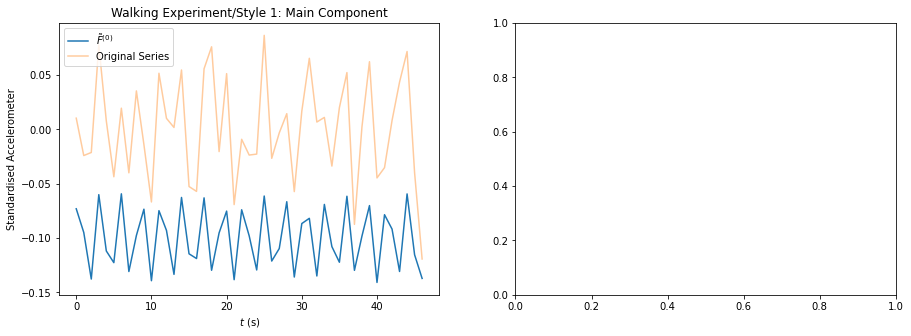

In [41]:
# Create plot
fig, axarr = plt.subplots(1, 2, figsize=(15,5))

# Plotting the decomposition style 1
(style1_ssa.reconstruct([0,1])-0.1).plot(ax=axarr[0])
style1_ssa.orig_TS.plot(alpha=0.4, ax=axarr[0])
axarr[0].set_title('Walking Experiment/Style 1: Main Component')
axarr[0].set_xlabel(r'$t$ (s)')
axarr[0].set_ylabel('Standardised Accelerometer')
legend = [r'$\tilde{{F}}^{{({0})}}$'.format(i) for i in range(1)] + ['Original Series']
axarr[0].legend(legend);

In [42]:
# Plotting the decomposition style 2
(style2_ssa.reconstruct([0,1])-0.1).plot(ax=axarr[1])
style2_ssa.orig_TS.plot(alpha=0.4, ax=axarr[1])
axarr[1].set_title('Walking Experiment/Style 2: Main Component')
axarr[1].set_xlabel(r'$t$ (s)')
axarr[1].set_ylabel('Standardised Accelerometer')
legend = [r'$\tilde{{F}}^{{({0})}}$'.format(i) for i in range(3)] + ['Original Series']
axarr[1].legend(legend);

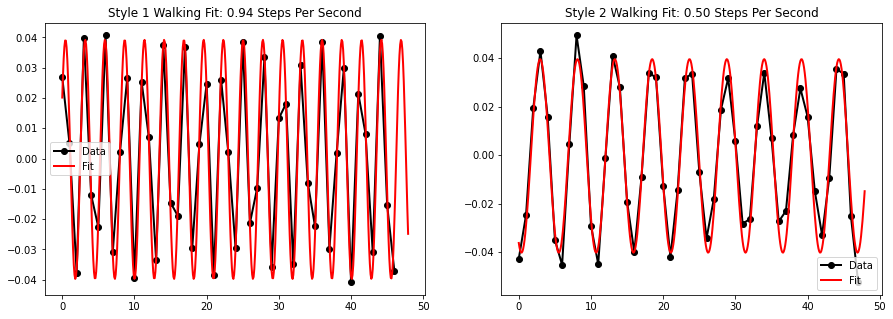

In [43]:
# Function to fit a sinus
def fit_sin(tt, yy):
    '''Fit sin to the input time sequence, and return fitting parameters "amp", "omega", "phase", "offset", "freq", "period" and "fitfunc"'''
    tt = np.array(tt)
    yy = np.array(yy)
    # Assume uniform spacing
    ff = np.fft.fftfreq(len(tt), (tt[1]-tt[0]))
    Fyy = abs(np.fft.fft(yy))
    # Exclude the zero frequency "peak"
    guess_freq = abs(ff[np.argmax(Fyy[1:])+1])
    guess_amp = np.std(yy) * 2.**0.5
    guess_offset = np.mean(yy)
    guess = np.array([guess_amp, 2.*np.pi*guess_freq, 0., guess_offset])

    # Sinus
    def sinfunc(t, A, w, p, c):  
        return A * np.sin(w*t + p) + c
    
    # Fit sinus
    popt, pcov = curve_fit(sinfunc, tt, yy, p0=guess)
    A, w, p, c = popt
    f = w/(2.*pi)
    fitfunc = lambda t: A * np.sin(w*t + p) + c
    return {"amp": A, "omega": w, "phase": p, "offset": c, "freq": f, "period": 1./f, "fitfunc": fitfunc, "maxcov": np.max(pcov), "rawres": (guess,popt,pcov)}

# Get data
main_style1 = style1_ssa.reconstruct([0, 1])
tt1 = main_style1.index
yy1 = main_style1.values
tt_res1 = np.arange(0, 48, 0.1)
# Fit data
res1 = fit_sin(tt1, yy1)

# Get data
main_style2 = style2_ssa.reconstruct([0, 1])
tt2 = main_style2.index
yy2 = main_style2.values
tt_res2 = np.arange(0, 48, 0.1)
# Fit data
res2 = fit_sin(tt2, yy2)

# Plot data
fig, axarr = plt.subplots(1, 2, figsize=(15,5))

# Plot data
axarr[0].plot(tt1, yy1, "-ok", label='Data', linewidth=2)
axarr[0].plot(tt_res1, res1['fitfunc'](tt_res1), "r-", label='Fit', linewidth=2)
axarr[0].set_title('Style 1 Walking Fit: {:.2f} Steps Per Second'.format((res1['omega']*1.28)/(pi)))
axarr[0].legend(loc="best")

axarr[1].plot(tt2, yy2, "-ok", label='Data', linewidth=2)
axarr[1].plot(tt_res2, res2['fitfunc'](tt_res2), "r-", label='Fit', linewidth=2)
axarr[1].set_title('Style 2 Walking Fit: {:.2f} Steps Per Second'.format((res2['omega']*1.28)/(pi)))
axarr[1].legend(loc="best")
plt.show()

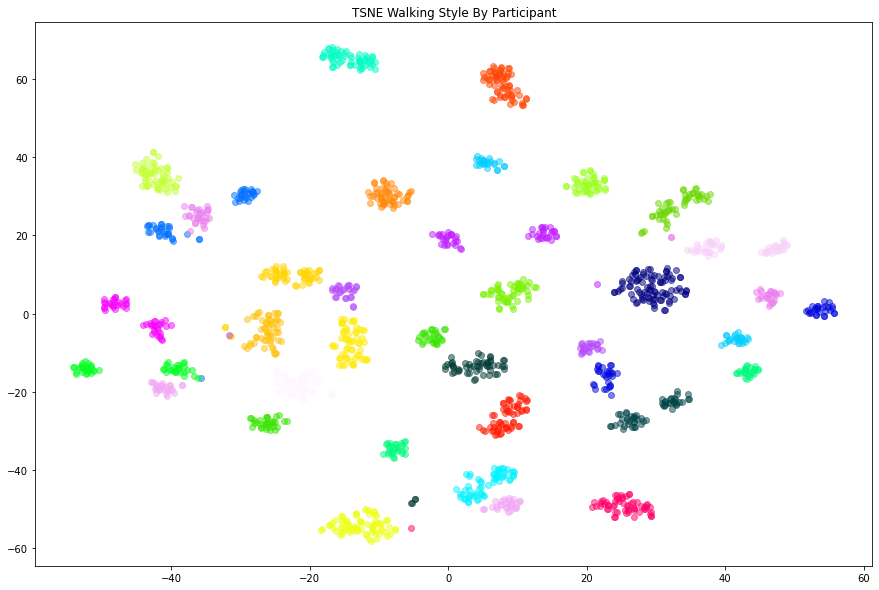

In [44]:
# Get data
tsne_data = both_df[label=='WALKING'].copy()
data_data = tsne_data.pop('Data')
subject_data = tsne_data.pop('subject')

# Scale data
scl = StandardScaler()
tsne_data = scl.fit_transform(tsne_data)

# Reduce dimensions
pca = PCA(n_components=0.9, random_state=3)
tsne_data = pca.fit_transform(tsne_data)

# Transform data
tsne = TSNE(random_state=3)
tsne_transformed = tsne.fit_transform(tsne_data)


# Create subplots
fig, axarr = plt.subplots(1, 1, figsize=(15,10))

### Plot Subjects
# Get colors
n = subject_data.unique().shape[0]
colormap = get_cmap('gist_ncar')
colors = [rgb2hex(colormap(col)) for col in np.arange(0, 1.01, 1/(n-1))]

for i, group in enumerate(subject_data.unique()):
    # Mask to separate sets
    mask = (subject_data==group).values
    axarr.scatter(x=tsne_transformed[mask][:,0], y=tsne_transformed[mask][:,1], c=colors[i], alpha=0.5, label=group)

axarr.set_title('TSNE Walking Style By Participant')
plt.show()

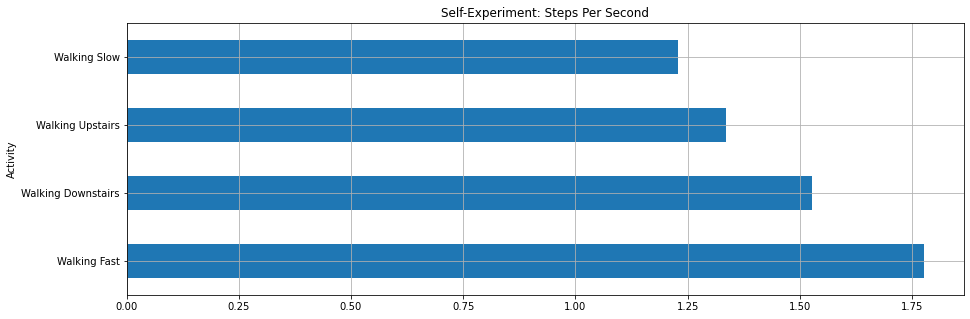

In [45]:
data = [['Walking Downstairs', 8.82, 15], 
        ['Walking Downstairs', 9.49, 15], 
        ['Walking Downstairs', 10.06, 15], 
        ['Walking Downstairs', 8.77, 15], 
        ['Walking Fast', 42.25, 80], 
        ['Walking Slow', 62.64, 80], 
        ['Walking Upstairs', 11.16, 15], 
        ['Walking Upstairs', 12.06, 15], 
        ['Walking Upstairs', 11.08, 15], 
        ['Walking Upstairs', 11.12, 15], 
        ['Walking Upstairs', 42.47, 60],
        ['Walking Downstairs', 10.334, 15],
        ['Walking Downstairs', 10.785, 15],
        ['Walking Downstairs', 10.487, 15],
        ['Walking Slow', 165.449, 200],
        ['Walking Fast', 115.360, 200],
        ['Walking Upstairs', 11.823, 15],
        ['Walking Upstairs', 11.872, 15],
        ['Walking Upstairs', 11.928, 15],
        ['Walking Upstairs', 11.351, 15]]

df = pd.DataFrame(data, columns=['Activity', 'Duration', 'Steps'])
activity_df = df.groupby('Activity').sum()
activity_df['Frequency'] = activity_df['Steps'] / activity_df['Duration']
activity_df.sort_values('Frequency', ascending=False)['Frequency'].plot(kind='barh', grid=True, figsize=(15,5))
plt.title('Self-Experiment: Steps Per Second')
plt.show()

In [46]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

import warnings
warnings.filterwarnings("ignore")

In [47]:
# Load datasets
train = pd.read_csv('train_HA.csv')
test = pd.read_csv('test_HA.csv')

In [48]:
print('Number of duplicates in train : ',sum(train.duplicated()))
print('Number of duplicates in test : ', sum(test.duplicated()))

Number of duplicates in train :  0
Number of duplicates in test :  0


In [49]:
print('Total number of missing values in train : ', train.isna().values.sum())
print('Total number of missing values in train : ', test.isna().values.sum())

Total number of missing values in train :  0
Total number of missing values in train :  0


(array([0, 1, 2, 3, 4, 5]), <a list of 6 Text major ticklabel objects>)

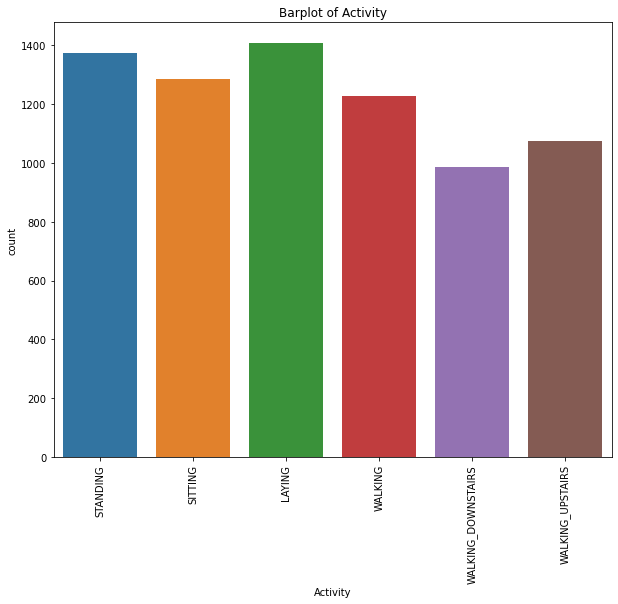

In [50]:
plt.figure(figsize=(10,8))
plt.title('Barplot of Activity')
sns.countplot(train.Activity)
plt.xticks(rotation=90)

Text(0.1, 9, 'Dynamic Activities')

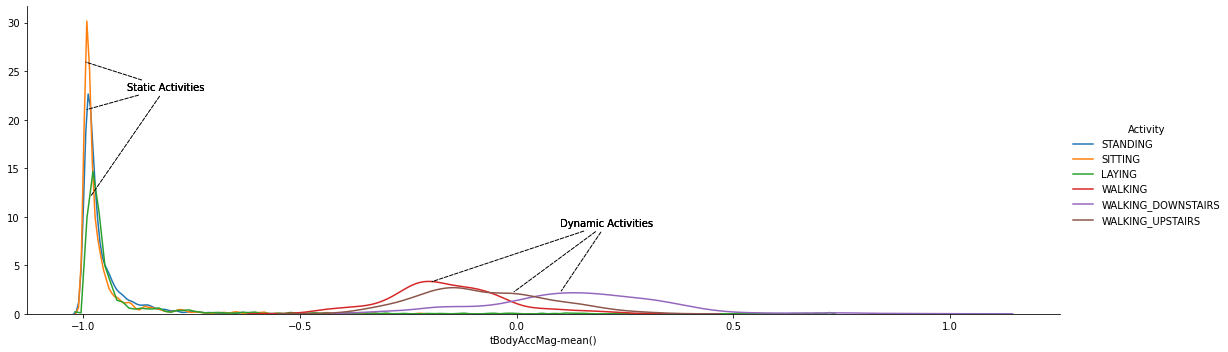

In [51]:
facetgrid = sns.FacetGrid(train, hue='Activity', height=5,aspect=3)
facetgrid.map(sns.distplot,'tBodyAccMag-mean()', hist=False).add_legend()
plt.annotate("Static Activities", xy=(-.996,21), xytext=(-0.9, 23),arrowprops={'arrowstyle': '-', 'ls': 'dashed'})
plt.annotate("Static Activities", xy=(-.999,26), xytext=(-0.9, 23),arrowprops={'arrowstyle': '-', 'ls': 'dashed'})
plt.annotate("Static Activities", xy=(-0.985,12), xytext=(-0.9, 23),arrowprops={'arrowstyle': '-', 'ls': 'dashed'})
plt.annotate("Dynamic Activities", xy=(-0.2,3.25), xytext=(0.1, 9),arrowprops={'arrowstyle': '-', 'ls': 'dashed'})
plt.annotate("Dynamic Activities", xy=(0.1,2.18), xytext=(0.1, 9),arrowprops={'arrowstyle': '-', 'ls': 'dashed'})
plt.annotate("Dynamic Activities", xy=(-0.01,2.15), xytext=(0.1, 9),arrowprops={'arrowstyle': '-', 'ls': 'dashed'})

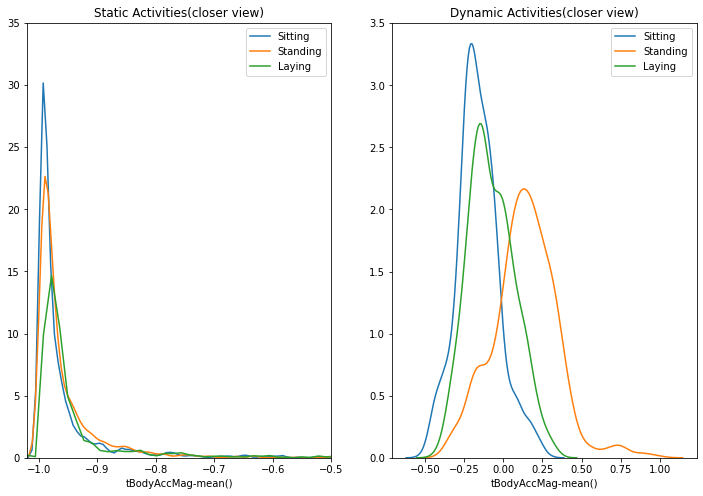

In [52]:
plt.figure(figsize=(12,8))
plt.subplot(1,2,1)
plt.title("Static Activities(closer view)")
sns.distplot(train[train["Activity"]=="SITTING"]['tBodyAccMag-mean()'],hist = False, label = 'Sitting')
sns.distplot(train[train["Activity"]=="STANDING"]['tBodyAccMag-mean()'],hist = False,label = 'Standing')
sns.distplot(train[train["Activity"]=="LAYING"]['tBodyAccMag-mean()'],hist = False, label = 'Laying')
plt.axis([-1.02, -0.5, 0, 35])
plt.subplot(1,2,2)
plt.title("Dynamic Activities(closer view)")
sns.distplot(train[train["Activity"]=="WALKING"]['tBodyAccMag-mean()'],hist = False, label = 'Sitting')
sns.distplot(train[train["Activity"]=="WALKING_DOWNSTAIRS"]['tBodyAccMag-mean()'],hist = False,label = 'Standing')
sns.distplot(train[train["Activity"]=="WALKING_UPSTAIRS"]['tBodyAccMag-mean()'],hist = False, label = 'Laying')

(array([0, 1, 2, 3, 4, 5]), <a list of 6 Text major ticklabel objects>)

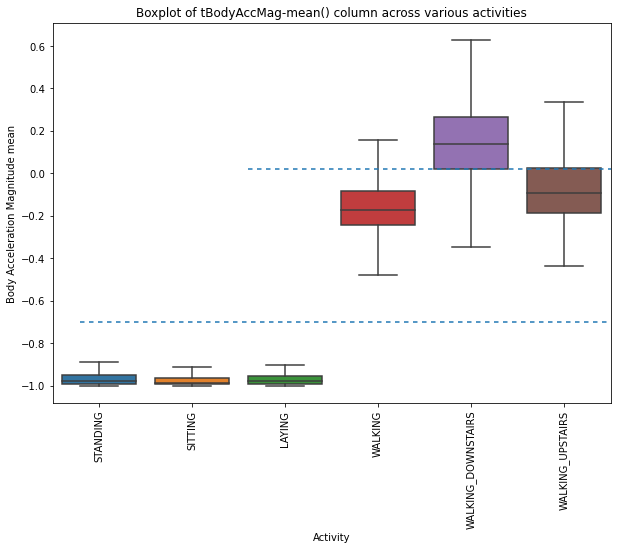

In [53]:
plt.figure(figsize=(10,7))
sns.boxplot(x='Activity', y='tBodyAccMag-mean()',data=train, showfliers=False)
plt.ylabel('Body Acceleration Magnitude mean')
plt.title("Boxplot of tBodyAccMag-mean() column across various activities")
plt.axhline(y=-0.7, xmin=0.05,dashes=(3,3))
plt.axhline(y=0.020, xmin=0.35, dashes=(3,3))
plt.xticks(rotation=90)

(array([0, 1, 2, 3, 4, 5]), <a list of 6 Text major ticklabel objects>)

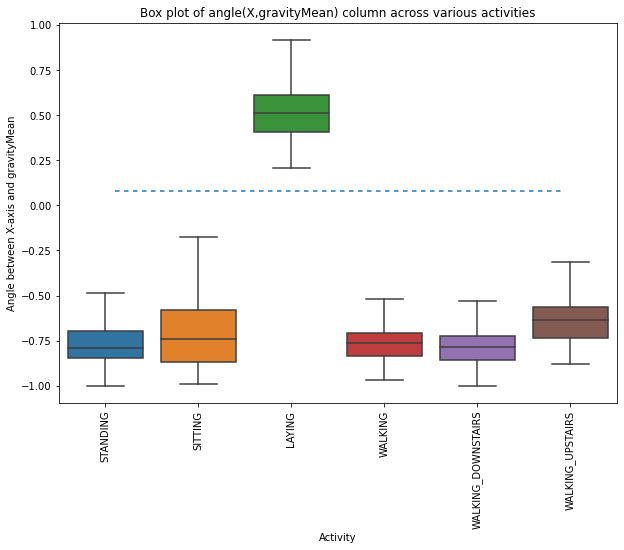

In [54]:
plt.figure(figsize=(10,7))
sns.boxplot(x='Activity', y='angle(X,gravityMean)', data=train, showfliers=False)
plt.axhline(y=0.08, xmin=0.1, xmax=0.9,dashes=(3,3))
plt.ylabel("Angle between X-axis and gravityMean")
plt.title('Box plot of angle(X,gravityMean) column across various activities')
plt.xticks(rotation = 90)

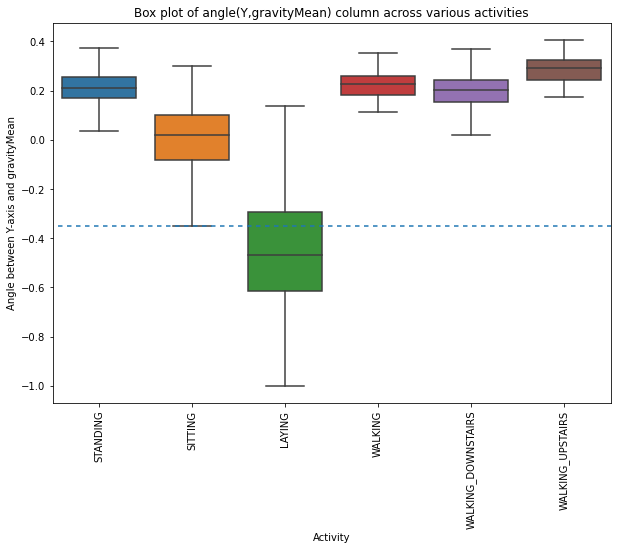

In [55]:
plt.figure(figsize=(10,7))
sns.boxplot(x='Activity', y='angle(Y,gravityMean)', data = train, showfliers=False)
plt.ylabel("Angle between Y-axis and gravityMean")
plt.title('Box plot of angle(Y,gravityMean) column across various activities')
plt.xticks(rotation = 90)
plt.axhline(y=-0.35, xmin=0.01, dashes=(3,3))

In [56]:
from sklearn.manifold import TSNE

In [57]:
X_for_tsne = train.drop(['subject', 'Activity'], axis=1)

In [58]:
%time
tsne = TSNE(random_state = 42, n_components=2, verbose=1, perplexity=50, n_iter=1000).fit_transform(X_for_tsne)

Wall time: 0 ns
[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 7352 samples in 0.913s...
[t-SNE] Computed neighbors for 7352 samples in 42.188s...
[t-SNE] Computed conditional probabilities for sample 1000 / 7352
[t-SNE] Computed conditional probabilities for sample 2000 / 7352
[t-SNE] Computed conditional probabilities for sample 3000 / 7352
[t-SNE] Computed conditional probabilities for sample 4000 / 7352
[t-SNE] Computed conditional probabilities for sample 5000 / 7352
[t-SNE] Computed conditional probabilities for sample 6000 / 7352
[t-SNE] Computed conditional probabilities for sample 7000 / 7352
[t-SNE] Computed conditional probabilities for sample 7352 / 7352
[t-SNE] Mean sigma: 1.437672
[t-SNE] KL divergence after 250 iterations with early exaggeration: 74.125374
[t-SNE] KL divergence after 1000 iterations: 1.282858


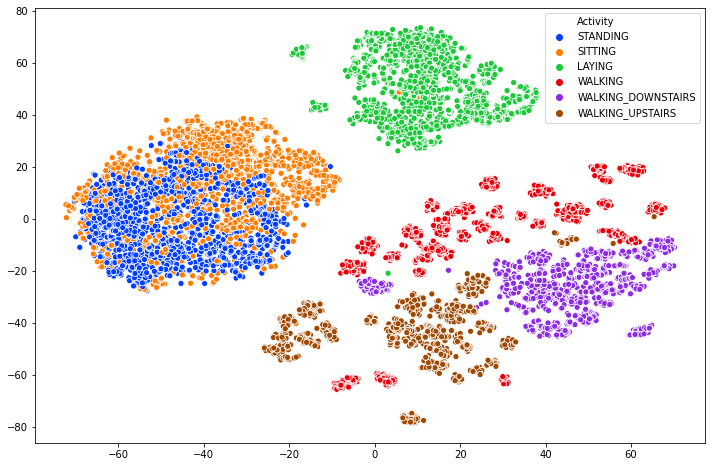

In [59]:
plt.figure(figsize=(12,8))
sns.scatterplot(x =tsne[:, 0], y = tsne[:, 1], hue = train["Activity"],palette="bright")

In [60]:
y_train = train.Activity
X_train = train.drop(['subject', 'Activity'], axis=1)
y_test = test.Activity
X_test = test.drop(['subject', 'Activity'], axis=1)
print('Training data size : ', X_train.shape)
print('Test data size : ', X_test.shape)

Training data size :  (7352, 561)
Test data size :  (2947, 561)


In [61]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

import warnings
warnings.filterwarnings("ignore")

In [62]:
parameters = {'C':np.arange(10,61,10), 'penalty':['l2','l1']}
lr_classifier = LogisticRegression()
lr_classifier_rs = RandomizedSearchCV(lr_classifier, param_distributions=parameters, cv=5,random_state = 42)
lr_classifier_rs.fit(X_train, y_train)
y_pred = lr_classifier_rs.predict(X_test)

In [63]:
lr_accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)
print("Accuracy using Logistic Regression : ", lr_accuracy)

Accuracy using Logistic Regression :  0.9555480149304377


In [64]:
# function to plot confusion matrix
def plot_confusion_matrix(cm,lables):
    fig, ax = plt.subplots(figsize=(12,8)) # for plotting confusion matrix as image
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),
    yticks=np.arange(cm.shape[0]),
    xticklabels=lables, yticklabels=lables,
    ylabel='True label',
    xlabel='Predicted label')
    plt.xticks(rotation = 90)
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, int(cm[i, j]),ha="center", va="center",color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()

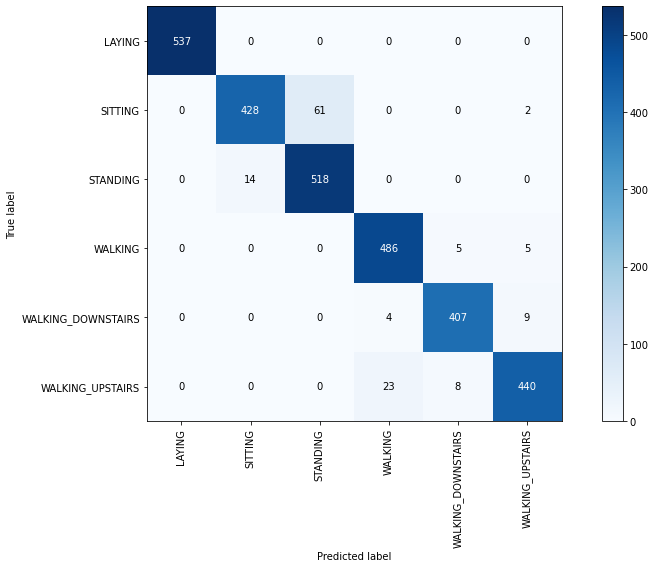

In [65]:
cm = confusion_matrix(y_test.values,y_pred)
plot_confusion_matrix(cm, np.unique(y_pred))  # plotting confusion matrix

In [66]:
#function to get best random search attributes
def get_best_randomsearch_results(model):
    print("Best estimator : ", model.best_estimator_)
    print("Best set of parameters : ", model.best_params_)
    print("Best score : ", model.best_score_)

In [67]:
# getting best random search attributes
get_best_randomsearch_results(lr_classifier_rs)

Best estimator :  LogisticRegression(C=60)
Best set of parameters :  {'penalty': 'l2', 'C': 60}
Best score :  0.9337660992337111


In [68]:
from sklearn.svm import LinearSVC

In [69]:
parameters = {'C':np.arange(1,12,2)}
lr_svm = LinearSVC(tol=0.00005)
lr_svm_rs = RandomizedSearchCV(lr_svm, param_distributions=parameters,random_state = 42)
lr_svm_rs.fit(X_train, y_train)
y_pred = lr_svm_rs.predict(X_test)

In [70]:
lr_svm_accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)
print("Accuracy using linear SVM : ",lr_svm_accuracy)

Accuracy using linear SVM :  0.9684424838819138


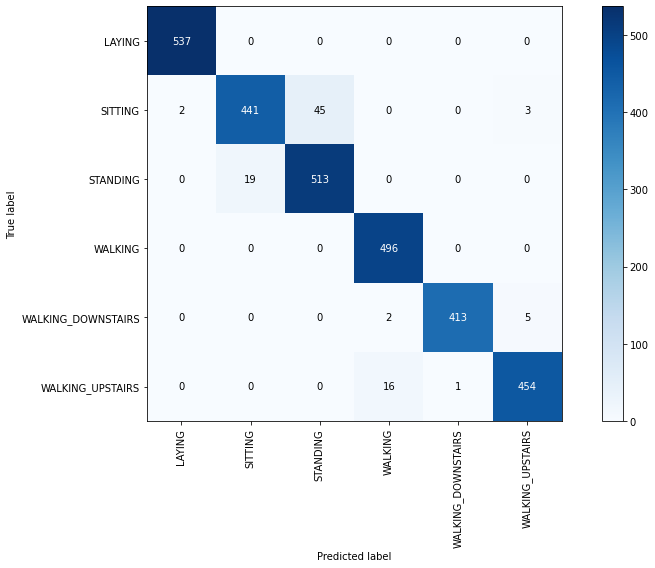

In [71]:
cm = confusion_matrix(y_test.values,y_pred)
plot_confusion_matrix(cm, np.unique(y_pred)) # plotting confusion matrix

In [72]:
# getting best random search attributes
get_best_randomsearch_results(lr_svm_rs)

Best estimator :  LinearSVC(C=3, tol=5e-05)
Best set of parameters :  {'C': 3}
Best score :  0.9417918302603162


In [73]:
from sklearn.svm import SVC

In [74]:
np.linspace(2,22,6)

array([ 2.,  6., 10., 14., 18., 22.])

In [85]:
parameters = {'C':[2,4,8,16],'gamma': [0.125, 0.250, 0.5, 1]}
kernel_svm = SVC(kernel='rbf')
kernel_svm_rs = RandomizedSearchCV(kernel_svm,param_distributions=parameters,random_state = 42)
kernel_svm_rs.fit(X_train, y_train)
y_pred = kernel_svm_rs.predict(X_test)

In [86]:
kernel_svm_accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)
print("Accuracy using Kernel SVM : ", kernel_svm_accuracy)

Accuracy using Kernel SVM :  0.9423142178486597


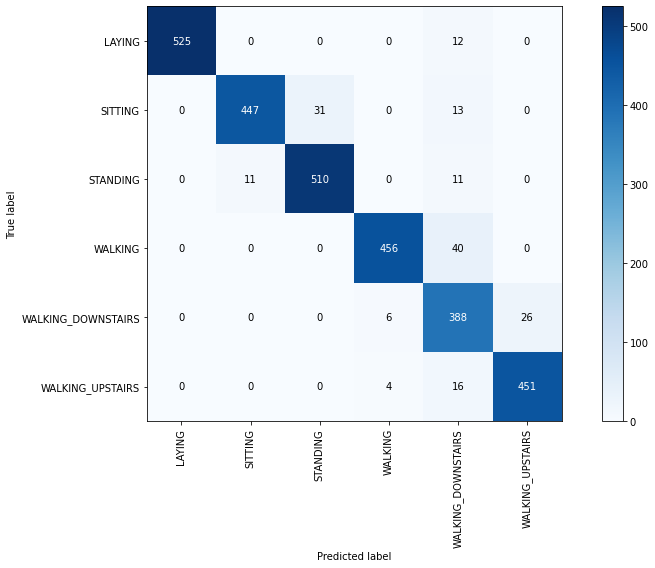

In [87]:
cm = confusion_matrix(y_test.values,y_pred)
plot_confusion_matrix(cm, np.unique(y_pred)) # plotting confusion matrix

In [88]:
# getting best random search attributes
get_best_randomsearch_results(kernel_svm_rs)

Best estimator :  SVC(C=8, gamma=0.125)
Best set of parameters :  {'gamma': 0.125, 'C': 8}
Best score :  0.896632121237346


In [77]:
from sklearn.tree import DecisionTreeClassifier
parameters = {'max_depth':np.arange(2,10,2)}
dt_classifier = DecisionTreeClassifier()
dt_classifier_rs = RandomizedSearchCV(dt_classifier,param_distributions=parameters,random_state = 42)
dt_classifier_rs.fit(X_train, y_train)
y_pred = dt_classifier_rs.predict(X_test)

In [78]:
dt_accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)
print("Accuracy using Decision tree : ", dt_accuracy)

Accuracy using Decision tree :  0.8724126230064473


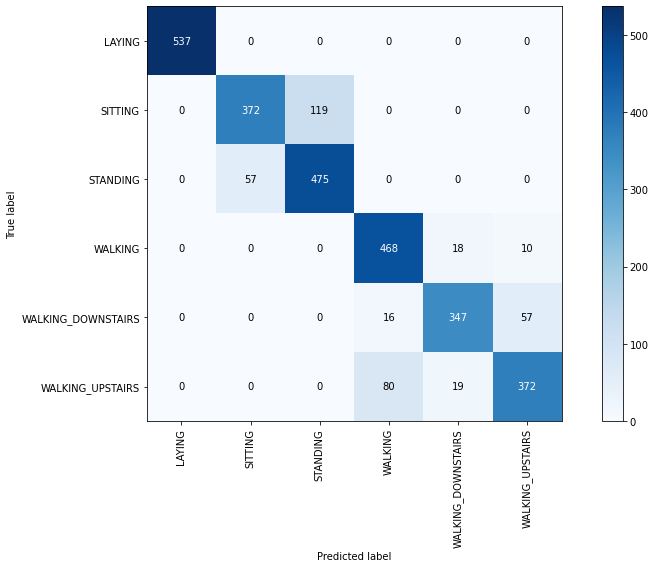

In [79]:
cm = confusion_matrix(y_test.values,y_pred)
plot_confusion_matrix(cm, np.unique(y_pred)) # plotting confusion matrix

In [80]:
# getting best random search attributes
get_best_randomsearch_results(dt_classifier_rs)

Best estimator :  DecisionTreeClassifier(max_depth=8)
Best set of parameters :  {'max_depth': 8}
Best score :  0.847259812150557


In [81]:
from sklearn.ensemble import RandomForestClassifier
params = {'n_estimators': np.arange(20,101,10), 'max_depth':np.arange(2,16,2)}
rf_classifier = RandomForestClassifier()
rf_classifier_rs = RandomizedSearchCV(rf_classifier, param_distributions=params,random_state = 42)
rf_classifier_rs.fit(X_train, y_train)
y_pred = rf_classifier_rs.predict(X_test)

In [82]:
rf_accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)
print("Accuracy using Random forest : ", rf_accuracy)

Accuracy using Random forest :  0.9192399049881235


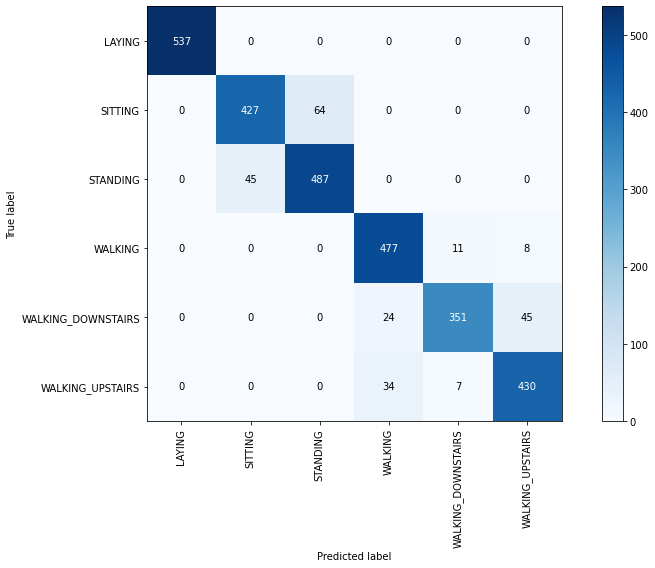

In [83]:
cm = confusion_matrix(y_test.values,y_pred)
plot_confusion_matrix(cm, np.unique(y_pred)) # plotting confusion matrix

In [84]:
# getting best random search attributes
get_best_randomsearch_results(rf_classifier_rs)

Best estimator :  RandomForestClassifier(max_depth=14, n_estimators=90)
Best set of parameters :  {'n_estimators': 90, 'max_depth': 14}
Best score :  0.9204345232314545
